# LPD Tile Testing

This is a notebook used to analyse/test single tiles. It does this by taking mean and standard deviation data of the input data and comparing this to preset thresholds (taken from good, working tiles). The same colourmap is used from the LPD GUI so tiles should look similar to how they do in the live view element of the GUI.

### Instructions to use:
1. Take data using LPD GUI
2. Open this notebook and select the file you wish to analyse from the list of files
3. Select which side and MINI connector the tile was connected to during the run you selected
4. Enable plots of trigger images and first full image if needed
5. Press 'Analyse Data' button

### Results of Analysis:
The results start with a table breaking down the results of the bad components of the tile, and giving details about which data has been used to come to that conclusion. Then there's a plot of the tile taking a mean value of each pixel, using each train in the file, resulting in a mean tile over the course of that run. A histogram follows this to show any variation in the data. The same thing is done again but by using the standard deviation of the data. The final mandatory plot shows a tile containing all the faults picked up by the analysis. You can also choose to see the first images from each trigger (currently images 1, 11, 21, 31) and the first full image in the file.

<IPython.core.display.Javascript object>


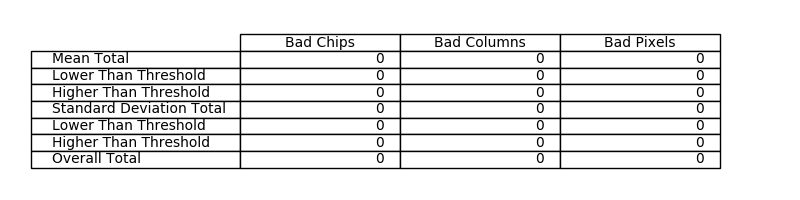

In [2]:
%matplotlib notebook

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from os import listdir, path
from os.path import isfile, join

from matplotlib.backends.backend_pdf import PdfPages

import extract_data
import test_results
import fault_tiles
import test_data
import plot
import generate_report

# Disable interactive mode and only use fig.show() to have a finer control over when plots are displayed
plt.ioff()

# Init variables
mean_fig = None
stdev_fig = None
fault_fig = None
fig_trigger = None
fig_first_image = None
results_table = None

data_file_path = '/data/lpd/matt/'

# Get all files in data_file_path and order them most recent to oldest
files = [f for f in listdir(data_file_path) if isfile(join(data_file_path, f)) and f.endswith('.h5')]
files.sort(key=lambda s: path.getmtime(join(data_file_path, s)), reverse=True)

select_file = widgets.Select(
    options=files,
    value=files[0]
)

select_file_label = widgets.Label(
    value = 'File to Analyse:',
    layout = widgets.Layout(width = '23%')
)

tile_choice = widgets.RadioButtons(
    options = ['Left Tile', 'Right Tile'],
    # TODO - Remove value selection as this is just for dev. purposes
    value = 'Right Tile',
    disabled = False
)
tile_choice_label = widgets.Label(
    value = 'Tile Orientation:',
    layout = widgets.Layout(width = '25%')
)


# Event handling for radio buttons
def on_change(change):
    # Avoid getting property lock etc.
    if change['type'] == 'change' and change['name'] == 'value':
        tile_choice.value = change['new']   

tile_choice.observe(on_change)

# Mini connector slider
mini_connector_selector = widgets.IntSlider(
    # TODO - Change default value to 1 - currently at 4 for dev. purposes
    value = 4,
    min = 1,
    max = 8,
    step = 1,
    orientation = 'horizontal'
)
mini_connector_label = widgets.Label(
    value = 'Mini Connector:',
    layout = widgets.Layout(width = '25%')
)

# Notice for checkboxes
checkbox_notice = widgets.Label(
    value = '(Once enabled, these plots will remain in the analysis until a kernel restart.)'
)

# Checkboxes
triggers_check = widgets.Checkbox(
    value=False,
    description='Show indivdual trigger images?',
)
first_image_check = widgets.Checkbox(
    value=False,
    description='Show first image?'
)

analyse_button = widgets.Button(
    description='Analyse Data'
)


# Event handling for analyse button
def on_button_clicked(b):
    analyse_data()
    
report_button = widgets.Button(
    description='Generate Report'
)


def report_button_clicked(b):
    pass
    
# Make buttons responsive to user input
analyse_button.on_click(on_button_clicked)
report_button.on_click(report_button_clicked)

# Arrange widgets into various groups so they display in a certain manner
tile_orientation_group = widgets.HBox([tile_choice_label, tile_choice], layout=widgets.Layout(height='60%'))
mini_connector_group = widgets.HBox([mini_connector_label, mini_connector_selector])
select_file_group = widgets.HBox([select_file_label, select_file])
checkbox_group = widgets.VBox([checkbox_notice, triggers_check, first_image_check])
main_left_group = widgets.VBox([tile_orientation_group, select_file_group, analyse_button, report_button])
main_right_group = widgets.VBox([mini_connector_group, checkbox_group])

# Display widgets
display(widgets.HBox([main_left_group, main_right_group]))

# Setup figures, subplots and results table
mean_fig, mean_tile_plot, mean_tile_colorbar, mean_histogram = plot.setup_test_plots(1)
stdev_fig, stdev_tile_plot, stdev_tile_colorbar, stdev_histogram = plot.setup_test_plots(2)
fault_fig, fault_tile_plot, fault_legend = plot.setup_fault_plots()
fig_results, results_table = test_results.show_test_results([0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], 
                                                            results_table)
fig_results.show()

fig_trigger, trigger_plots, trigger_colorbar = plot.setup_trigger_plots()
fig_first_image, first_image_plot, first_image_colorbar = plot.setup_first_image_plot()


def analyse_data():
    try:
        # Create PDF file using Matplotlib backend
        pdf_file = PdfPages('test_results.pdf')
        
        # Select file from select box
        lpd_file_name = data_file_path + select_file.value

        # Disable analyse button until testing is complete
        analyse_button.disabled = True

        # Clear data from all subplots to ensure no new data isn't overlaid on old data
        mean_tile_plot.cla()
        mean_histogram.cla()
        stdev_tile_plot.cla()
        stdev_histogram.cla()
        fault_tile_plot.cla()
        if trigger_plots is not None:
            for trigger_plot in trigger_plots:
                trigger_plot.cla()
        first_image_plot.cla()

        # Set titles of all plots - would've been cleared by cla()
        plot.set_plot_titles(mean_tile_plot, mean_histogram, stdev_tile_plot, stdev_histogram, fault_tile_plot, 
                             trigger_plots, first_image_plot)

        lpd_data = extract_data.get_lpd_data(lpd_file_name)
        tile_position = extract_data.set_tile_position(tile_choice.value, mini_connector_selector.value)
        mean_tile = extract_data.get_mean_tile(lpd_data, tile_position)
        stdev_tile = extract_data.get_stdev_tile(lpd_data, tile_position)

        fault_tile = np.zeros((32, 128), dtype=np.int32)

        # Mean data test with plots of mean tile and histogram
        bad_chips_mean = test_data.bad_chips(mean_tile, fault_tile, 1)
        bad_cols_mean = test_data.bad_columns(mean_tile, fault_tile, 1)
        bad_pixels_mean = test_data.bad_pixels(mean_tile, fault_tile, 1)
        test_data.manage_figure(mean_tile, mean_tile_plot, mean_tile_colorbar, mean_histogram, 0)
        mean_fig.savefig(pdf_file, format='pdf')
        mean_fig.show()

        # Test using standard deviation data
        bad_chips_stdev = test_data.bad_chips(stdev_tile, fault_tile, 2)
        bad_cols_stdev = test_data.bad_columns(stdev_tile, fault_tile, 2)
        bad_pixels_stdev = test_data.bad_pixels(stdev_tile, fault_tile, 2)
        test_data.manage_figure(stdev_tile, stdev_tile_plot, stdev_tile_colorbar, stdev_histogram, 1)
        stdev_fig.savefig(pdf_file, format='pdf')
        stdev_fig.show()

        # Plotting fault image
        fault_tiles.plot_faults(fault_tile_plot, fault_tile)
        fault_fig.savefig(pdf_file, format='pdf')
        fault_fig.show()

        # Display bad components of tile as text
        test_results.show_test_results(bad_chips_mean, bad_chips_stdev, bad_cols_mean, bad_cols_stdev, 
                                                       bad_pixels_mean, bad_pixels_stdev, results_table)

        # Acting on checkbox statuses
        if triggers_check.value:
            test_results.display_trigger_images(lpd_data, tile_position, fig_trigger, trigger_plots, trigger_colorbar)
            fig_trigger.set_visible(True)
            fig_trigger.show()

        if first_image_check.value:
            test_results.display_first_image(lpd_data, first_image_plot, first_image_colorbar)
            fig_first_image.show()
    
    finally:
        # Enable analyse button as testing is complete or failed
        analyse_button.disabled = False
        pdf_file.close()
        